In [1]:
import pandas as pd
import quandl, datetime, math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
%matplotlib notebook

In [2]:
df = quandl.get('WIKI/GOOGL')

In [3]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [4]:
df1 = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

df1['HL_PCT'] = ((df1['Adj. High'] - df1['Adj. Close']) / df1['Adj. Close']) * 100.0
df1['PCT_change'] = ((df1['Adj. Close'] - df1['Adj. Open']) / df1['Adj. Open']) * 100.0

df1.head()

<ipython-input-4-bee6bc838c04>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['HL_PCT'] = ((df1['Adj. High'] - df1['Adj. Close']) / df1['Adj. Close']) * 100.0
<ipython-input-4-bee6bc838c04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PCT_change'] = ((df1['Adj. Close'] - df1['Adj. Open']) / df1['Adj. Open']) * 100.0


,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,3.712563,0.324968
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,0.710922,7.227007
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,3.729433,-1.227880
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,6.417469,-5.726357
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,1.886792,1.183658


In [5]:
df2 = df1[['Adj. Close', 'Adj. Volume', 'HL_PCT', 'PCT_change']]

In [6]:
forecast_col = 'Adj. Close'
forecast_out = int(math.ceil(0.01*len(df2)))
df2['label'] = df2[forecast_col].shift(-forecast_out)
df2

<ipython-input-6-4a32999fff04>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = df2[forecast_col].shift(-forecast_out)


,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
Date,,,,,
2004-08-19,50.322842,44659000.0,3.712563,0.324968,69.078238
2004-08-20,54.322689,22834300.0,0.710922,7.227007,67.839414
2004-08-23,54.869377,18256100.0,3.729433,-1.227880,68.912727
2004-08-24,52.597363,15247300.0,6.417469,-5.726357,70.668146
2004-08-25,53.164113,9188600.0,1.886792,1.183658,71.219849
...,...,...,...,...,...
2018-03-21,1094.000000,1990515.0,1.343693,0.130884,NaN
2018-03-22,1053.150000,3418154.0,2.921711,-2.487014,NaN
2018-03-23,1026.550000,2413517.0,3.918952,-2.360729,NaN


In [7]:
print(forecast_col,forecast_out)

Adj. Close 35


In [8]:
df2.isna().sum()

Adj. Close      0
Adj. Volume     0
HL_PCT          0
PCT_change      0
label          35
dtype: int64

In [9]:
X = np.array(df2.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
print(len(X))
X = X[:-forecast_out]
print(len(X))
df2.dropna(inplace=True)
y = np.array(df2.label)
print(df2.isna().sum())

3424
3389
Adj. Close     0
Adj. Volume    0
HL_PCT         0
PCT_change     0
label          0
dtype: int64


<ipython-input-9-08bce69d0360>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(inplace=True)


<IPython.core.display.Javascript object>


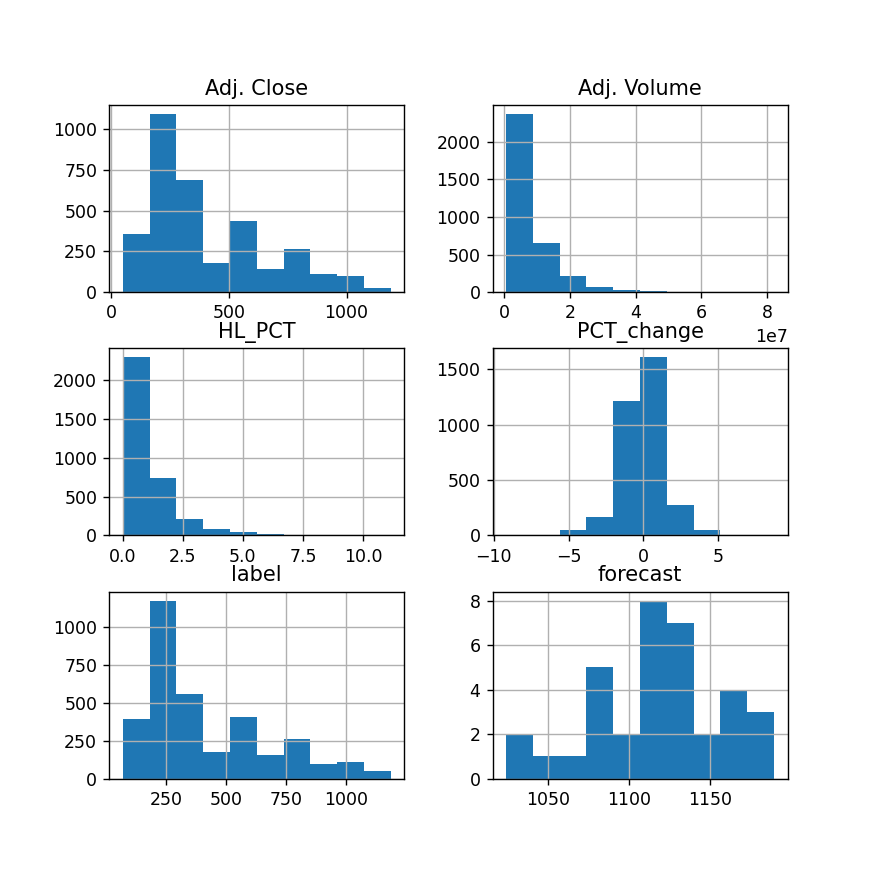

array([[<AxesSubplot:title={'center':'Adj. Close'}>,
        <AxesSubplot:title={'center':'Adj. Volume'}>],
       [<AxesSubplot:title={'center':'HL_PCT'}>,
        <AxesSubplot:title={'center':'PCT_change'}>],
       [<AxesSubplot:title={'center':'label'}>,
        <AxesSubplot:title={'center':'forecast'}>]], dtype=object)

In [21]:
df2.hist(figsize = (7,7))

In [11]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
#linear model
lin = LinearRegression(n_jobs=-1)
lin.fit(X_train, y_train)
lin.score(X_test,y_test)

0.9780695036849565

In [13]:
#svm 
svm_model = svm.SVR()
svm_model.fit(X_train, y_train)
svm_model.score(X_test,y_test)

0.762256048673501

In [14]:
#predict the forecast data
predict_forecast = lin.predict(X_lately)
predict_forecast

array([1108.68500362, 1076.10283536, 1023.71825176, 1065.57957503,
       1076.64371179, 1076.95856363, 1096.23139136, 1114.85269684,
       1118.52419304, 1127.13034597, 1136.83458782, 1132.87551635,
       1152.36616716, 1168.18699833, 1139.52130373, 1125.95313873,
       1091.75558347, 1107.93242245, 1118.62187052, 1124.37833431,
       1139.46402081, 1153.64034979, 1185.67364969, 1189.84924564,
       1161.77312959, 1172.71175612, 1174.50230831, 1156.7706859 ,
       1121.96076358, 1118.50503722, 1116.9227227 , 1073.61155211,
       1046.73977309, 1076.36474396, 1025.05778185])

In [15]:
df2['forecast'] = np.nan
last_date = df2.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in predict_forecast:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df2.loc[next_date] = [np.nan for _ in range(len(df2.columns)-1)] +[i]
df2

<ipython-input-15-dc286e295802>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['forecast'] = np.nan
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,forecast
Date,,,,,,
2004-08-19 00:00:00,50.322842,44659000.0,3.712563,0.324968,69.078238,NaN
2004-08-20 00:00:00,54.322689,22834300.0,0.710922,7.227007,67.839414,NaN
2004-08-23 00:00:00,54.869377,18256100.0,3.729433,-1.227880,68.912727,NaN
2004-08-24 00:00:00,52.597363,15247300.0,6.417469,-5.726357,70.668146,NaN
2004-08-25 00:00:00,53.164113,9188600.0,1.886792,1.183658,71.219849,NaN
...,...,...,...,...,...,...
2018-03-08 05:30:00,NaN,NaN,NaN,NaN,NaN,1116.922723
2018-03-09 05:30:00,NaN,NaN,NaN,NaN,NaN,1073.611552
2018-03-10 05:30:00,NaN,NaN,NaN,NaN,NaN,1046.739773


<IPython.core.display.Javascript object>


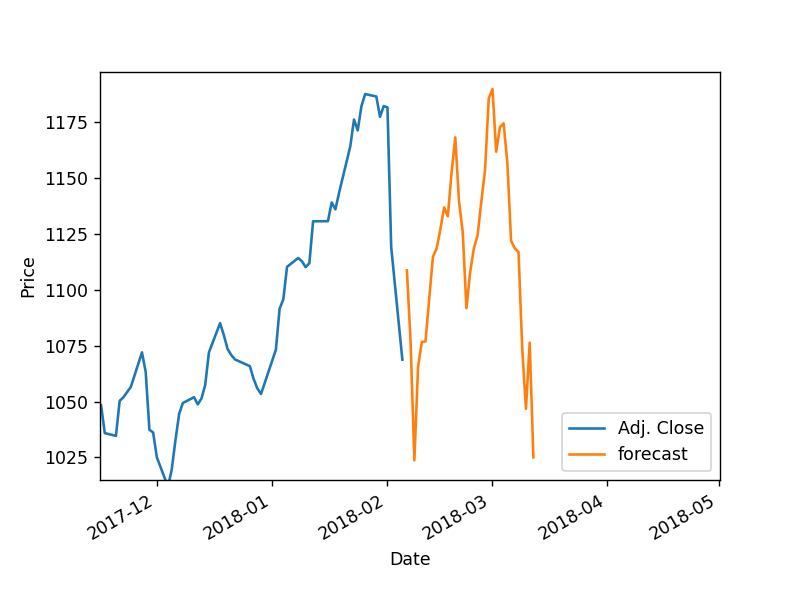

In [22]:
df2['Adj. Close'].plot()
df2['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [17]:
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(lin, f)

pickle_in = open ('linearregression.pickle', 'rb')
lin1 = pickle.load(pickle_in)

In [18]:
lin1.predict(X_lately)

array([1108.68500362, 1076.10283536, 1023.71825176, 1065.57957503,
       1076.64371179, 1076.95856363, 1096.23139136, 1114.85269684,
       1118.52419304, 1127.13034597, 1136.83458782, 1132.87551635,
       1152.36616716, 1168.18699833, 1139.52130373, 1125.95313873,
       1091.75558347, 1107.93242245, 1118.62187052, 1124.37833431,
       1139.46402081, 1153.64034979, 1185.67364969, 1189.84924564,
       1161.77312959, 1172.71175612, 1174.50230831, 1156.7706859 ,
       1121.96076358, 1118.50503722, 1116.9227227 , 1073.61155211,
       1046.73977309, 1076.36474396, 1025.05778185])